# **First Code**

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 18.4 MB/s eta 0:00:00


Cell 1 – Imports & Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
import optuna

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")


Cell 2 – Load Data & Initial Cleaning

In [ ]:
df = pd.read_csv('/content/sample_data/dengue data 17-07-2025.csv')
df.drop(columns=['city', 'week_start_date'], inplace=True)
df.fillna(method='ffill', inplace=True)
df.index

RangeIndex(start=0, stop=1456, step=1)

Cell 3 – Feature Engineering + Outlier Removal

In [ ]:
# Outlier removal using IQR
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df < (Q1 - 1.5*IQR)) | (df > (Q3 + 1.5*IQR))).any(axis=1)]

df = remove_outliers(df)

# Add lag features
for lag in [1, 2, 3]:
    df[f'total_cases_lag{lag}'] = df['total_cases'].shift(lag)
df.dropna(inplace=True)

# # Outlier removal using IQR
# def remove_outliers(df):
#     Q1 = df.quantile(0.25)
#     Q3 = df.quantile(0.75)
#     IQR = Q3 - Q1
#     return df[~((df < (Q1 - 1.5*IQR)) | (df > (Q3 + 1.5*IQR))).any(axis=1)]

# df = remove_outliers(df)

# # Add lag features
# for lag in [1, 2, 3]:
#     df[f'total_cases_lag{lag}'] = df['total_cases'].shift(lag)
# df['month'] = pd.to_datetime(df['week_start_date'], format='%Y-%m-%d').dt.month
# df.dropna(inplace=True)


Index([ 18,  21,  22,  35,  36,  39,  41,  42,  43,  44,
       ...
       913, 914, 918, 923, 925, 926, 928, 931, 932, 934],
      dtype='int64', length=454)

Cell 4 – Feature Filtering and Scaling

In [ ]:
# Target column
target_col = 'total_cases'
features = df.drop(columns=[target_col])

# Remove low variance & high correlation
def drop_low_variance(df, thresh=0.01):
    sel = VarianceThreshold(thresh)
    return df[df.columns[sel.fit(df).get_support()]]
def drop_high_corr(df, thresh=0.9):
    corr = df.corr().abs()
    up = corr.where(np.triu(np.ones(corr.shape),1).astype(bool))
    drop = [c for c in up.columns if any(up[c] > thresh)]
    return df.drop(columns=drop)

features = drop_low_variance(features)
features = drop_high_corr(features)

# Scale features & target
feat_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
X_feat = feat_scaler.fit_transform(features)
y = df[target_col].values.reshape(-1,1)
y_scaled = target_scaler.fit_transform(y)

# # Target column
# target_col = 'total_cases'
# features = df.drop(columns=[target_col, 'week_start_date'])

# # Remove low variance & high correlation
# def drop_low_variance(df, thresh=0.01):
#     sel = VarianceThreshold(thresh)
#     return df[df.columns[sel.fit(df).get_support()]]
# def drop_high_corr(df, thresh=0.9):
#     corr = df.corr().abs()
#     up = corr.where(np.triu(np.ones(corr.shape),1).astype(bool))
#     drop = [c for c in up.columns if any(up[c] > thresh)]
#     return df.drop(columns=drop)

# features = drop_low_variance(features)
# features = drop_high_corr(features)

# # Scale features & target
# feat_scaler = MinMaxScaler()
# target_scaler = MinMaxScaler()
# X_feat = feat_scaler.fit_transform(features)
# y = df[target_col].values.reshape(-1,1)
# y_scaled = target_scaler.fit_transform(y)


Cell 5 – Sequence Creation & Split

In [ ]:
window = 10
X, y_seq = [], []
for i in range(len(y_scaled)-window):
    X.append(X_feat[i:i+window])
    y_seq.append(y_scaled[i+window])
X, y_seq = np.array(X), np.array(y_seq)

# Split: Train 70%, Val 10%, Test 20%
idx = len(X)
test_size = int(0.2*idx)
val_size = int(0.1*idx)

X_train, X_val, X_test = X[:-test_size-val_size], X[-test_size-val_size:-test_size], X[-test_size:]
y_train, y_val, y_test = y_seq[:-test_size-val_size], y_seq[-test_size-val_size:-test_size], y_seq[-test_size:]


Cell 6 – Optuna Tuning

In [ ]:
def create_model(input_shape, trial):
    model = Sequential()
    n = trial.suggest_int('neurons', 64, 256, step=32)
    model.add(LSTM(n, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(trial.suggest_uniform('drop',0.0,0.5)))
    model.add(LSTM(n//2))
    model.add(Dropout(trial.suggest_uniform('drop2',0.0,0.5)))
    model.add(Dense(1))
    opt = trial.suggest_categorical('opt', ['adam','nadam','rmsprop'])
    model.compile(optimizer=opt, loss='mse')
    return model

def objective(trial):
    model = create_model((window, X.shape[2]), trial)
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=100, batch_size=trial.suggest_categorical('bs',[16,32,64]),
              validation_data=(X_val,y_val), callbacks=[es], verbose=0)
    pred = model.predict(X_val)
    return mean_squared_error(y_val, pred)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best hyperparameters:", study.best_trial.params)


[I 2025-07-24 06:55:00,853] A new study created in memory with name: no-name-2a7413a9-e9ff-4622-8915-107d93487ed9


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step


[I 2025-07-24 06:55:30,984] Trial 0 finished with value: 0.01911916958204309 and parameters: {'neurons': 256, 'drop': 0.48070225013878887, 'drop2': 0.35948017764996254, 'opt': 'nadam', 'bs': 32}. Best is trial 0 with value: 0.01911916958204309.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step


[I 2025-07-24 06:55:48,282] Trial 1 finished with value: 0.018162147138921846 and parameters: {'neurons': 64, 'drop': 0.307850941612097, 'drop2': 0.2532597639922215, 'opt': 'nadam', 'bs': 32}. Best is trial 1 with value: 0.018162147138921846.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 422ms/step


[I 2025-07-24 06:56:05,246] Trial 2 finished with value: 0.019404690084597286 and parameters: {'neurons': 128, 'drop': 0.2422641424950751, 'drop2': 0.3340642737283435, 'opt': 'nadam', 'bs': 32}. Best is trial 1 with value: 0.018162147138921846.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step


[I 2025-07-24 06:56:20,353] Trial 3 finished with value: 0.01941929082508408 and parameters: {'neurons': 64, 'drop': 0.31726372143639886, 'drop2': 0.38802469214382734, 'opt': 'rmsprop', 'bs': 32}. Best is trial 1 with value: 0.018162147138921846.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step


[I 2025-07-24 06:56:39,276] Trial 4 finished with value: 0.01907842849285359 and parameters: {'neurons': 64, 'drop': 0.27365412597470923, 'drop2': 0.2713243413879883, 'opt': 'adam', 'bs': 32}. Best is trial 1 with value: 0.018162147138921846.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step


[I 2025-07-24 06:57:00,136] Trial 5 finished with value: 0.016895826241138973 and parameters: {'neurons': 160, 'drop': 0.20750878162155967, 'drop2': 0.1680774732397644, 'opt': 'nadam', 'bs': 16}. Best is trial 5 with value: 0.016895826241138973.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step


[I 2025-07-24 06:57:20,701] Trial 6 finished with value: 0.017941112098523674 and parameters: {'neurons': 64, 'drop': 0.44368498416156066, 'drop2': 0.3857091864090311, 'opt': 'rmsprop', 'bs': 16}. Best is trial 5 with value: 0.016895826241138973.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step


[I 2025-07-24 06:57:39,400] Trial 7 finished with value: 0.018245442222720426 and parameters: {'neurons': 64, 'drop': 0.2733981898943771, 'drop2': 0.4628240102421118, 'opt': 'rmsprop', 'bs': 16}. Best is trial 5 with value: 0.016895826241138973.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step


[I 2025-07-24 06:58:01,841] Trial 8 finished with value: 0.01643938865745209 and parameters: {'neurons': 96, 'drop': 0.4993935541191241, 'drop2': 0.1730030426374244, 'opt': 'rmsprop', 'bs': 32}. Best is trial 8 with value: 0.01643938865745209.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step


[I 2025-07-24 06:58:38,620] Trial 9 finished with value: 0.016503285069327994 and parameters: {'neurons': 256, 'drop': 0.27239712199870814, 'drop2': 0.43728636224001527, 'opt': 'adam', 'bs': 64}. Best is trial 8 with value: 0.01643938865745209.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step


[I 2025-07-24 06:58:54,022] Trial 10 finished with value: 0.018745626240206387 and parameters: {'neurons': 128, 'drop': 0.007340793766864695, 'drop2': 0.054152223798074384, 'opt': 'rmsprop', 'bs': 64}. Best is trial 8 with value: 0.01643938865745209.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step


[I 2025-07-24 06:59:23,985] Trial 11 finished with value: 0.018682585404224062 and parameters: {'neurons': 256, 'drop': 0.11596830272797937, 'drop2': 0.12041793289889913, 'opt': 'adam', 'bs': 64}. Best is trial 8 with value: 0.01643938865745209.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step


[I 2025-07-24 06:59:48,519] Trial 12 finished with value: 0.019057539986253192 and parameters: {'neurons': 224, 'drop': 0.4041259250314424, 'drop2': 0.4932461590671137, 'opt': 'adam', 'bs': 64}. Best is trial 8 with value: 0.01643938865745209.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step


[I 2025-07-24 07:00:27,751] Trial 13 finished with value: 0.015740593603958904 and parameters: {'neurons': 192, 'drop': 0.360552442512428, 'drop2': 0.18626173985154781, 'opt': 'adam', 'bs': 64}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step


[I 2025-07-24 07:00:49,793] Trial 14 finished with value: 0.01875587490361711 and parameters: {'neurons': 192, 'drop': 0.37239789009284147, 'drop2': 0.17361966430761203, 'opt': 'rmsprop', 'bs': 64}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step


[I 2025-07-24 07:01:05,848] Trial 15 finished with value: 0.017840669588944782 and parameters: {'neurons': 128, 'drop': 0.38636143016486035, 'drop2': 0.023941846655091803, 'opt': 'adam', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step


[I 2025-07-24 07:01:35,078] Trial 16 finished with value: 0.016976056890098047 and parameters: {'neurons': 192, 'drop': 0.49814160414963193, 'drop2': 0.1913477610313729, 'opt': 'adam', 'bs': 64}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step


[I 2025-07-24 07:01:59,137] Trial 17 finished with value: 0.01809640882886502 and parameters: {'neurons': 160, 'drop': 0.16553569366472878, 'drop2': 0.10337248894966766, 'opt': 'rmsprop', 'bs': 64}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step


[I 2025-07-24 07:02:12,174] Trial 18 finished with value: 0.019354182022711434 and parameters: {'neurons': 96, 'drop': 0.4313373162993507, 'drop2': 0.30099160642433687, 'opt': 'rmsprop', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


[I 2025-07-24 07:02:39,545] Trial 19 finished with value: 0.016917319420325403 and parameters: {'neurons': 192, 'drop': 0.3489204894843659, 'drop2': 0.2200823739758878, 'opt': 'adam', 'bs': 16}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step


[I 2025-07-24 07:02:56,383] Trial 20 finished with value: 0.019230413718022126 and parameters: {'neurons': 96, 'drop': 0.4447152362718101, 'drop2': 0.12878619938598052, 'opt': 'rmsprop', 'bs': 64}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step


[I 2025-07-24 07:03:33,447] Trial 21 finished with value: 0.01742256172172523 and parameters: {'neurons': 224, 'drop': 0.33295247017672325, 'drop2': 0.4380866041694873, 'opt': 'adam', 'bs': 64}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step


[I 2025-07-24 07:03:57,459] Trial 22 finished with value: 0.019299420363753966 and parameters: {'neurons': 224, 'drop': 0.19029418607929438, 'drop2': 0.23056398003771872, 'opt': 'adam', 'bs': 64}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step


[I 2025-07-24 07:04:24,481] Trial 23 finished with value: 0.017905707586756716 and parameters: {'neurons': 256, 'drop': 0.1048723408631867, 'drop2': 0.30154271705536895, 'opt': 'adam', 'bs': 64}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step


[I 2025-07-24 07:04:38,201] Trial 24 finished with value: 0.018268907086816204 and parameters: {'neurons': 96, 'drop': 0.24185996940835253, 'drop2': 0.06528417957750034, 'opt': 'adam', 'bs': 64}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 395ms/step


[I 2025-07-24 07:05:07,138] Trial 25 finished with value: 0.016136746577786885 and parameters: {'neurons': 224, 'drop': 0.2860016994160364, 'drop2': 0.1974590303827531, 'opt': 'adam', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step


[I 2025-07-24 07:05:33,504] Trial 26 finished with value: 0.018031493423199325 and parameters: {'neurons': 160, 'drop': 0.4111391880807482, 'drop2': 0.14888389202095811, 'opt': 'adam', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step


[I 2025-07-24 07:06:04,144] Trial 27 finished with value: 0.01677999447180055 and parameters: {'neurons': 192, 'drop': 0.4693885087876862, 'drop2': 0.2085836352813087, 'opt': 'adam', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step


[I 2025-07-24 07:06:30,355] Trial 28 finished with value: 0.016380940178757932 and parameters: {'neurons': 224, 'drop': 0.3664128837628838, 'drop2': 0.08694865898252507, 'opt': 'nadam', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 419ms/step


[I 2025-07-24 07:06:57,618] Trial 29 finished with value: 0.01616491192024766 and parameters: {'neurons': 224, 'drop': 0.3621229458453132, 'drop2': 0.07717656160567704, 'opt': 'nadam', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step


[I 2025-07-24 07:07:20,241] Trial 30 finished with value: 0.01803108262186035 and parameters: {'neurons': 224, 'drop': 0.30783866032523255, 'drop2': 0.018848505838112914, 'opt': 'nadam', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step


[I 2025-07-24 07:07:45,363] Trial 31 finished with value: 0.01766766885954557 and parameters: {'neurons': 224, 'drop': 0.3651574000984408, 'drop2': 0.08457022859829773, 'opt': 'nadam', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 423ms/step


[I 2025-07-24 07:08:11,053] Trial 32 finished with value: 0.017637472223152744 and parameters: {'neurons': 192, 'drop': 0.30243856524449547, 'drop2': 0.046967565934888766, 'opt': 'nadam', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step


[I 2025-07-24 07:08:31,750] Trial 33 finished with value: 0.01806980039199593 and parameters: {'neurons': 224, 'drop': 0.3409115663159096, 'drop2': 0.0892338895433979, 'opt': 'nadam', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


[I 2025-07-24 07:08:54,441] Trial 34 finished with value: 0.017577604941762928 and parameters: {'neurons': 224, 'drop': 0.38912992621384357, 'drop2': 0.13795903036385787, 'opt': 'nadam', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 346ms/step


[I 2025-07-24 07:09:33,305] Trial 35 finished with value: 0.01716327942509518 and parameters: {'neurons': 256, 'drop': 0.29478401424426676, 'drop2': 0.24901631141145847, 'opt': 'nadam', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step


[I 2025-07-24 07:09:55,524] Trial 36 finished with value: 0.017793261667888898 and parameters: {'neurons': 192, 'drop': 0.24301744909200695, 'drop2': 0.1049362913745233, 'opt': 'nadam', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step


[I 2025-07-24 07:10:30,177] Trial 37 finished with value: 0.01811924495452845 and parameters: {'neurons': 256, 'drop': 0.3428268572469933, 'drop2': 0.19268024563848066, 'opt': 'nadam', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step


[I 2025-07-24 07:11:12,886] Trial 38 finished with value: 0.016920659702677344 and parameters: {'neurons': 224, 'drop': 0.4175483524536629, 'drop2': 0.2875266463759064, 'opt': 'nadam', 'bs': 16}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step


[I 2025-07-24 07:11:39,498] Trial 39 finished with value: 0.01728976577704377 and parameters: {'neurons': 192, 'drop': 0.4610285153033143, 'drop2': 0.15435382768202455, 'opt': 'nadam', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step


[I 2025-07-24 07:12:08,609] Trial 40 finished with value: 0.01720560516591116 and parameters: {'neurons': 160, 'drop': 0.3197713709466118, 'drop2': 0.004412956404978963, 'opt': 'nadam', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step


[I 2025-07-24 07:12:46,605] Trial 41 finished with value: 0.016134022886956038 and parameters: {'neurons': 224, 'drop': 0.21745520075741182, 'drop2': 0.17115948232939165, 'opt': 'rmsprop', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step


[I 2025-07-24 07:13:13,985] Trial 42 finished with value: 0.01676252815612565 and parameters: {'neurons': 224, 'drop': 0.26844949924812544, 'drop2': 0.248031927504359, 'opt': 'rmsprop', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 472ms/step


[I 2025-07-24 07:13:45,985] Trial 43 finished with value: 0.016686882568080073 and parameters: {'neurons': 256, 'drop': 0.21095138209253814, 'drop2': 0.06965120454932909, 'opt': 'nadam', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step


[I 2025-07-24 07:14:23,681] Trial 44 finished with value: 0.017238777923229507 and parameters: {'neurons': 224, 'drop': 0.36122025322626966, 'drop2': 0.1858490075707189, 'opt': 'rmsprop', 'bs': 16}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step


[I 2025-07-24 07:14:42,651] Trial 45 finished with value: 0.019834005353901642 and parameters: {'neurons': 192, 'drop': 0.28721624529960743, 'drop2': 0.12071656244895426, 'opt': 'adam', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step


[I 2025-07-24 07:15:29,682] Trial 46 finished with value: 0.016491750736923137 and parameters: {'neurons': 256, 'drop': 0.20822657790896115, 'drop2': 0.15127807469111665, 'opt': 'rmsprop', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step


[I 2025-07-24 07:15:57,441] Trial 47 finished with value: 0.016260962144413135 and parameters: {'neurons': 224, 'drop': 0.14823105934047162, 'drop2': 0.3274274020481984, 'opt': 'adam', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step


[I 2025-07-24 07:16:29,565] Trial 48 finished with value: 0.01592867897134371 and parameters: {'neurons': 192, 'drop': 0.13372660576492185, 'drop2': 0.34699332677004013, 'opt': 'adam', 'bs': 16}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step


[I 2025-07-24 07:16:57,798] Trial 49 finished with value: 0.01700898933396283 and parameters: {'neurons': 192, 'drop': 0.047303075955868135, 'drop2': 0.37134913430028793, 'opt': 'adam', 'bs': 16}. Best is trial 13 with value: 0.015740593603958904.


Best hyperparameters: {'neurons': 192, 'drop': 0.360552442512428, 'drop2': 0.18626173985154781, 'opt': 'adam', 'bs': 64}


Cell 7 – Final Model Training

In [ ]:
p = study.best_trial.params
model = Sequential([
    LSTM(p['neurons'], return_sequences=True, input_shape=(window,X.shape[2])),
    Dropout(p['drop']),
    LSTM(p['neurons']//2),
    Dropout(p['drop2']),
    Dense(1)
])
model.compile(optimizer=p['opt'], loss='mse')
es = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
model.fit(X_train, y_train, epochs=150, batch_size=p['bs'],
          validation_data=(X_val,y_val), callbacks=[es], verbose=4)


NameError: name 'study' is not defined

Cell 8 – Predict & Inverse Scale

In [ ]:
pred_scaled = model.predict(X_test)
pred = target_scaler.inverse_transform(pred_scaled)
actual = target_scaler.inverse_transform(y_test)

mse = mean_squared_error(actual, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, pred)
print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
MSE: 73.87, RMSE: 8.59, MAE: 6.80


Cell 9 – Plot Predictions vs Actual

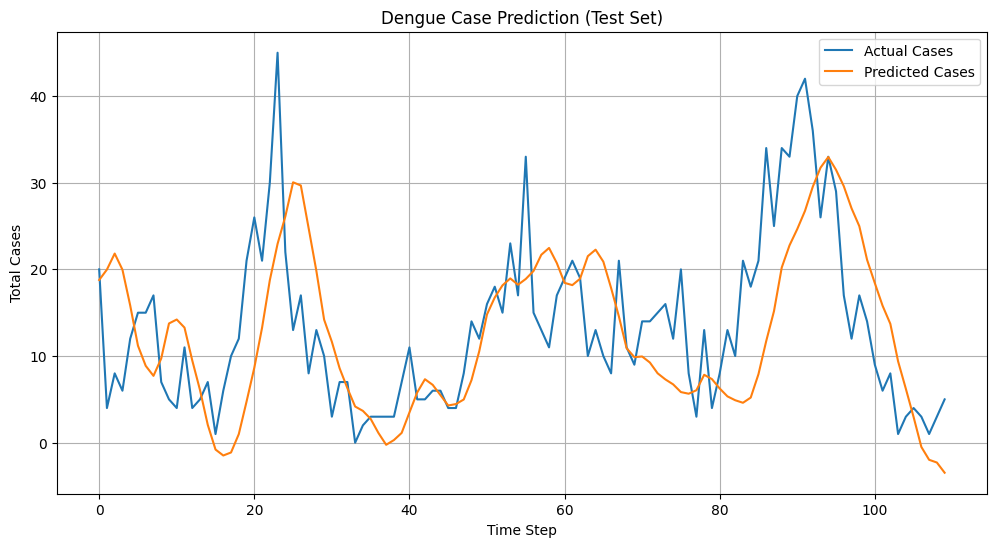

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(actual, label='Actual Cases')
plt.plot(pred, label='Predicted Cases')
plt.title('Dengue Case Prediction (Test Set)')
plt.xlabel('Time Step')
plt.ylabel('Total Cases')
plt.legend()
plt.grid(True)
plt.show()


# **Second Code**

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 14.5 MB/s eta 0:00:00


Cell 1: Imports & Setup

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
import optuna

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")


Cell 2: Load Data & Initial Cleaning

In [7]:
df = pd.read_csv('/content/sample_data/dengue data 17-07-2025.csv')

# Keep 'week_start_date' for feature engineering but drop 'city'
df.drop(columns=['city'], inplace=True)
df.fillna(method='ffill', inplace=True)


Cell 3: Remove Outliers & Feature Engineering

In [8]:
# Remove outliers based on IQR for all numeric columns except date and target
def remove_outliers(df, target_col='total_cases'):
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    numeric_cols.remove(target_col)
    Q1 = df[numeric_cols].quantile(0.25)
    Q3 = df[numeric_cols].quantile(0.75)
    IQR = Q3 - Q1
    filter_ = ~((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)
    return df[filter_]

df = remove_outliers(df)

# Extract month from 'week_start_date'
df['month'] = pd.to_datetime(df['week_start_date']).dt.month

# Create lag features for 'total_cases' (lags 1 to 6)
for lag in range(1, 7):
    df[f'total_cases_lag_{lag}'] = df['total_cases'].shift(lag)

# Rolling mean and std dev of 'total_cases' over last 3 weeks
df['rolling_mean_3'] = df['total_cases'].rolling(window=3).mean()
df['rolling_std_3'] = df['total_cases'].rolling(window=3).std()

# Drop rows with NaNs due to lagging
df.dropna(inplace=True)

# Drop date column (used month already)
df.drop(columns=['week_start_date'], inplace=True)


Cell 4: Remove Low-Variance & Highly Correlated Features

In [9]:
target_col = 'total_cases'

# Separate features and target
features = df.drop(columns=[target_col])
target = df[target_col]

# Remove low variance features
selector = VarianceThreshold(threshold=0.01)
features = features.loc[:, selector.fit(features).get_support()]

# Remove highly correlated features (threshold 0.9)
corr_matrix = features.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > 0.9)]
features.drop(columns=to_drop, inplace=True)

print("Remaining features after variance & correlation filtering:\n", features.columns)


Remaining features after variance & correlation filtering:
 Index(['year', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'precipitation_amt_mm',
       'reanalysis_air_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'station_avg_temp_c',
       'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c',
       'station_precip_mm', 'total_cases_lag_1', 'rolling_std_3'],
      dtype='object')


Cell 5: Scaling Features and Target

In [10]:
feat_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

features_scaled = feat_scaler.fit_transform(features)
target_scaled = target_scaler.fit_transform(target.values.reshape(-1, 1))


Cell 6: Create Sequences for LSTM & Train-Val-Test Split

In [11]:
window_size = 10
X, y = [], []

for i in range(len(features_scaled) - window_size):
    X.append(features_scaled[i:i+window_size])
    y.append(target_scaled[i+window_size])

X = np.array(X)
y = np.array(y)

# Split data: 70% train, 15% val, 15% test (time series split - no shuffle)
total_len = len(X)
train_len = int(0.7 * total_len)
val_len = int(0.15 * total_len)

X_train, y_train = X[:train_len], y[:train_len]
X_val, y_val = X[train_len:train_len + val_len], y[train_len:train_len + val_len]
X_test, y_test = X[train_len + val_len:], y[train_len + val_len:]


Cell 7: Define Model and Objective for Optuna Hyperparameter Tuning

In [12]:
def create_model(input_shape, trial):
    model = Sequential()
    n_layers = trial.suggest_int('n_layers', 1, 3)
    for i in range(n_layers):
        units = trial.suggest_int(f'units_l{i}', 64, 256, step=32)
        return_seq = i < n_layers - 1
        if i == 0:
            model.add(LSTM(units, return_sequences=return_seq, input_shape=input_shape))
        else:
            model.add(LSTM(units, return_sequences=return_seq))
        model.add(Dropout(trial.suggest_float(f'dropout_l{i}', 0.1, 0.5)))
    model.add(Dense(1))
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'nadam', 'rmsprop'])
    model.compile(optimizer=optimizer, loss='mse')
    return model

def objective(trial):
    model = create_model((window_size, X.shape[2]), trial)
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=trial.suggest_categorical('batch_size', [16, 32, 64]),
        callbacks=[early_stop],
        verbose=0
    )
    pred_val = model.predict(X_val)
    val_mse = mean_squared_error(y_val, pred_val)
    return val_mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best parameters:", study.best_trial.params)


[I 2025-07-24 10:46:37,151] A new study created in memory with name: no-name-a644e75e-d2f4-4e68-b215-fef4b0b00af0


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


[I 2025-07-24 10:47:04,496] Trial 0 finished with value: 0.0015377236057923474 and parameters: {'n_layers': 2, 'units_l0': 64, 'dropout_l0': 0.17465758252654756, 'units_l1': 128, 'dropout_l1': 0.2610865480494472, 'optimizer': 'adam', 'batch_size': 16}. Best is trial 0 with value: 0.0015377236057923474.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


[I 2025-07-24 10:48:20,895] Trial 1 finished with value: 0.0026039644115560543 and parameters: {'n_layers': 3, 'units_l0': 256, 'dropout_l0': 0.22648033147208868, 'units_l1': 224, 'dropout_l1': 0.35525150851889886, 'units_l2': 160, 'dropout_l2': 0.23126202333321402, 'optimizer': 'nadam', 'batch_size': 16}. Best is trial 0 with value: 0.0015377236057923474.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step


[I 2025-07-24 10:50:23,874] Trial 2 finished with value: 0.0032643762050637956 and parameters: {'n_layers': 3, 'units_l0': 256, 'dropout_l0': 0.3439716192249447, 'units_l1': 160, 'dropout_l1': 0.4251031136206128, 'units_l2': 128, 'dropout_l2': 0.18647516355381316, 'optimizer': 'rmsprop', 'batch_size': 16}. Best is trial 0 with value: 0.0015377236057923474.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


[I 2025-07-24 10:50:54,015] Trial 3 finished with value: 0.004566383648496791 and parameters: {'n_layers': 2, 'units_l0': 64, 'dropout_l0': 0.36921577416162654, 'units_l1': 224, 'dropout_l1': 0.19282002301459236, 'optimizer': 'nadam', 'batch_size': 32}. Best is trial 0 with value: 0.0015377236057923474.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


[I 2025-07-24 10:51:16,768] Trial 4 finished with value: 0.002476413165039049 and parameters: {'n_layers': 2, 'units_l0': 192, 'dropout_l0': 0.29774977685822074, 'units_l1': 128, 'dropout_l1': 0.12658471256285453, 'optimizer': 'nadam', 'batch_size': 64}. Best is trial 0 with value: 0.0015377236057923474.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step


[I 2025-07-24 10:53:05,440] Trial 5 finished with value: 0.0011303775992082246 and parameters: {'n_layers': 3, 'units_l0': 96, 'dropout_l0': 0.30089357013749063, 'units_l1': 256, 'dropout_l1': 0.41093158146631203, 'units_l2': 160, 'dropout_l2': 0.4328766694635414, 'optimizer': 'adam', 'batch_size': 16}. Best is trial 5 with value: 0.0011303775992082246.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[I 2025-07-24 10:53:24,058] Trial 6 finished with value: 0.003980584920153798 and parameters: {'n_layers': 1, 'units_l0': 160, 'dropout_l0': 0.3384891154658216, 'optimizer': 'nadam', 'batch_size': 16}. Best is trial 5 with value: 0.0011303775992082246.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step


[I 2025-07-24 10:54:01,432] Trial 7 finished with value: 0.0010944583263492273 and parameters: {'n_layers': 3, 'units_l0': 96, 'dropout_l0': 0.46872341311798504, 'units_l1': 224, 'dropout_l1': 0.31140216051748426, 'units_l2': 224, 'dropout_l2': 0.48326643390712376, 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 7 with value: 0.0010944583263492273.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


[I 2025-07-24 10:54:20,756] Trial 8 finished with value: 0.0012746266007326423 and parameters: {'n_layers': 2, 'units_l0': 192, 'dropout_l0': 0.3390537731775016, 'units_l1': 160, 'dropout_l1': 0.1624262383916012, 'optimizer': 'adam', 'batch_size': 64}. Best is trial 7 with value: 0.0010944583263492273.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step


[I 2025-07-24 10:55:06,390] Trial 9 finished with value: 0.0016717353136232198 and parameters: {'n_layers': 3, 'units_l0': 128, 'dropout_l0': 0.23650842181297255, 'units_l1': 128, 'dropout_l1': 0.12378963983844252, 'units_l2': 64, 'dropout_l2': 0.49221002753395415, 'optimizer': 'adam', 'batch_size': 16}. Best is trial 7 with value: 0.0010944583263492273.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[I 2025-07-24 10:55:15,523] Trial 10 finished with value: 0.0016014215717269338 and parameters: {'n_layers': 1, 'units_l0': 128, 'dropout_l0': 0.4985359839597743, 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 7 with value: 0.0010944583263492273.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step


[I 2025-07-24 10:56:03,142] Trial 11 finished with value: 0.0012809054094580165 and parameters: {'n_layers': 3, 'units_l0': 96, 'dropout_l0': 0.46162942588530903, 'units_l1': 256, 'dropout_l1': 0.4966959416705735, 'units_l2': 256, 'dropout_l2': 0.47408738899971586, 'optimizer': 'rmsprop', 'batch_size': 32}. Best is trial 7 with value: 0.0010944583263492273.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


[I 2025-07-24 10:56:54,043] Trial 12 finished with value: 0.001203461852609643 and parameters: {'n_layers': 3, 'units_l0': 96, 'dropout_l0': 0.4284367854626543, 'units_l1': 256, 'dropout_l1': 0.35293720329337785, 'units_l2': 256, 'dropout_l2': 0.3820418720685721, 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 7 with value: 0.0010944583263492273.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step


[I 2025-07-24 10:57:27,042] Trial 13 finished with value: 0.0012292460148193868 and parameters: {'n_layers': 3, 'units_l0': 96, 'dropout_l0': 0.1326985705515688, 'units_l1': 224, 'dropout_l1': 0.2852560578960838, 'units_l2': 192, 'dropout_l2': 0.363680258796681, 'optimizer': 'adam', 'batch_size': 64}. Best is trial 7 with value: 0.0010944583263492273.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step


[I 2025-07-24 10:58:03,447] Trial 14 finished with value: 0.0015342652580143641 and parameters: {'n_layers': 3, 'units_l0': 128, 'dropout_l0': 0.42072994047398243, 'units_l1': 192, 'dropout_l1': 0.3961738463221536, 'units_l2': 192, 'dropout_l2': 0.4121321223384555, 'optimizer': 'rmsprop', 'batch_size': 32}. Best is trial 7 with value: 0.0010944583263492273.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


[I 2025-07-24 10:58:20,531] Trial 15 finished with value: 0.006551459349865196 and parameters: {'n_layers': 2, 'units_l0': 64, 'dropout_l0': 0.2574263161294584, 'units_l1': 64, 'dropout_l1': 0.459962210009649, 'optimizer': 'adam', 'batch_size': 16}. Best is trial 7 with value: 0.0010944583263492273.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


[I 2025-07-24 10:59:04,814] Trial 16 finished with value: 0.0013660283939286874 and parameters: {'n_layers': 3, 'units_l0': 160, 'dropout_l0': 0.39580655861952346, 'units_l1': 256, 'dropout_l1': 0.2349936022491487, 'units_l2': 128, 'dropout_l2': 0.325062314055829, 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 7 with value: 0.0010944583263492273.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


[I 2025-07-24 11:00:16,647] Trial 17 finished with value: 0.0009562061478822029 and parameters: {'n_layers': 2, 'units_l0': 96, 'dropout_l0': 0.1051201547324489, 'units_l1': 192, 'dropout_l1': 0.32485911803497775, 'optimizer': 'adam', 'batch_size': 16}. Best is trial 17 with value: 0.0009562061478822029.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


[I 2025-07-24 11:00:28,064] Trial 18 finished with value: 0.0016218077036158375 and parameters: {'n_layers': 1, 'units_l0': 192, 'dropout_l0': 0.10869463941840611, 'optimizer': 'adam', 'batch_size': 64}. Best is trial 17 with value: 0.0009562061478822029.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


[I 2025-07-24 11:00:50,256] Trial 19 finished with value: 0.001102149418347955 and parameters: {'n_layers': 2, 'units_l0': 128, 'dropout_l0': 0.1753572525344846, 'units_l1': 192, 'dropout_l1': 0.3378285501868595, 'optimizer': 'rmsprop', 'batch_size': 32}. Best is trial 17 with value: 0.0009562061478822029.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


[I 2025-07-24 11:01:07,826] Trial 20 finished with value: 0.0015377472769186541 and parameters: {'n_layers': 1, 'units_l0': 160, 'dropout_l0': 0.49999641834308806, 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 17 with value: 0.0009562061478822029.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


[I 2025-07-24 11:01:30,266] Trial 21 finished with value: 0.0011614551107070883 and parameters: {'n_layers': 2, 'units_l0': 128, 'dropout_l0': 0.16594406877646528, 'units_l1': 192, 'dropout_l1': 0.33383244082391345, 'optimizer': 'rmsprop', 'batch_size': 32}. Best is trial 17 with value: 0.0009562061478822029.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


[I 2025-07-24 11:01:50,664] Trial 22 finished with value: 0.0014230641631346077 and parameters: {'n_layers': 2, 'units_l0': 96, 'dropout_l0': 0.18201370181117957, 'units_l1': 192, 'dropout_l1': 0.31128419544998415, 'optimizer': 'rmsprop', 'batch_size': 32}. Best is trial 17 with value: 0.0009562061478822029.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


[I 2025-07-24 11:02:14,566] Trial 23 finished with value: 0.0012858119537784089 and parameters: {'n_layers': 2, 'units_l0': 128, 'dropout_l0': 0.10251309046803284, 'units_l1': 192, 'dropout_l1': 0.24396134008656128, 'optimizer': 'rmsprop', 'batch_size': 32}. Best is trial 17 with value: 0.0009562061478822029.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


[I 2025-07-24 11:02:39,472] Trial 24 finished with value: 0.002031914869715554 and parameters: {'n_layers': 2, 'units_l0': 64, 'dropout_l0': 0.1458903461131509, 'units_l1': 224, 'dropout_l1': 0.30307779638388693, 'optimizer': 'rmsprop', 'batch_size': 32}. Best is trial 17 with value: 0.0009562061478822029.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step


[I 2025-07-24 11:02:59,654] Trial 25 finished with value: 0.0016257626115230134 and parameters: {'n_layers': 2, 'units_l0': 96, 'dropout_l0': 0.20564704132040848, 'units_l1': 160, 'dropout_l1': 0.3753245628457586, 'optimizer': 'adam', 'batch_size': 32}. Best is trial 17 with value: 0.0009562061478822029.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


[I 2025-07-24 11:03:28,551] Trial 26 finished with value: 0.0023265171145420167 and parameters: {'n_layers': 2, 'units_l0': 128, 'dropout_l0': 0.27666912751202094, 'units_l1': 192, 'dropout_l1': 0.3267770563407072, 'optimizer': 'rmsprop', 'batch_size': 16}. Best is trial 17 with value: 0.0009562061478822029.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


[I 2025-07-24 11:03:55,120] Trial 27 finished with value: 0.0023719312336871684 and parameters: {'n_layers': 1, 'units_l0': 224, 'dropout_l0': 0.2048925829004944, 'optimizer': 'rmsprop', 'batch_size': 16}. Best is trial 17 with value: 0.0009562061478822029.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


[I 2025-07-24 11:04:11,262] Trial 28 finished with value: 0.0027411880877843014 and parameters: {'n_layers': 2, 'units_l0': 96, 'dropout_l0': 0.14299275317814675, 'units_l1': 160, 'dropout_l1': 0.27902991117746, 'optimizer': 'nadam', 'batch_size': 64}. Best is trial 17 with value: 0.0009562061478822029.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


[I 2025-07-24 11:04:33,717] Trial 29 finished with value: 0.001742541184161118 and parameters: {'n_layers': 2, 'units_l0': 64, 'dropout_l0': 0.16538174638035308, 'units_l1': 224, 'dropout_l1': 0.216606983436621, 'optimizer': 'adam', 'batch_size': 32}. Best is trial 17 with value: 0.0009562061478822029.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-07-24 11:04:44,102] Trial 30 finished with value: 0.0024488457373610796 and parameters: {'n_layers': 1, 'units_l0': 64, 'dropout_l0': 0.1161579551355609, 'optimizer': 'adam', 'batch_size': 16}. Best is trial 17 with value: 0.0009562061478822029.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


[I 2025-07-24 11:06:19,235] Trial 31 finished with value: 0.001521537029675151 and parameters: {'n_layers': 3, 'units_l0': 96, 'dropout_l0': 0.27677565398800363, 'units_l1': 256, 'dropout_l1': 0.3967941119111056, 'units_l2': 224, 'dropout_l2': 0.4295053938450317, 'optimizer': 'adam', 'batch_size': 16}. Best is trial 17 with value: 0.0009562061478822029.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step


[I 2025-07-24 11:08:45,801] Trial 32 finished with value: 0.0017719829230580964 and parameters: {'n_layers': 3, 'units_l0': 96, 'dropout_l0': 0.19266588591310213, 'units_l1': 224, 'dropout_l1': 0.43528621818014646, 'units_l2': 160, 'dropout_l2': 0.2571804764259161, 'optimizer': 'adam', 'batch_size': 16}. Best is trial 17 with value: 0.0009562061478822029.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step


[I 2025-07-24 11:10:12,989] Trial 33 finished with value: 0.00095759827364357 and parameters: {'n_layers': 3, 'units_l0': 128, 'dropout_l0': 0.23226271757174816, 'units_l1': 256, 'dropout_l1': 0.38260804844557617, 'units_l2': 64, 'dropout_l2': 0.10933377157204041, 'optimizer': 'adam', 'batch_size': 16}. Best is trial 17 with value: 0.0009562061478822029.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step


[I 2025-07-24 11:11:17,084] Trial 34 finished with value: 0.0009147460914640434 and parameters: {'n_layers': 3, 'units_l0': 128, 'dropout_l0': 0.22605226291028274, 'units_l1': 192, 'dropout_l1': 0.36284316558087887, 'units_l2': 64, 'dropout_l2': 0.11875024670054704, 'optimizer': 'adam', 'batch_size': 16}. Best is trial 34 with value: 0.0009147460914640434.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step


[I 2025-07-24 11:12:05,899] Trial 35 finished with value: 0.0009404160020682189 and parameters: {'n_layers': 3, 'units_l0': 160, 'dropout_l0': 0.21630726827703925, 'units_l1': 224, 'dropout_l1': 0.3689733477061068, 'units_l2': 64, 'dropout_l2': 0.10111305547446331, 'optimizer': 'adam', 'batch_size': 16}. Best is trial 34 with value: 0.0009147460914640434.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step


[I 2025-07-24 11:13:02,412] Trial 36 finished with value: 0.0013897583635103605 and parameters: {'n_layers': 3, 'units_l0': 160, 'dropout_l0': 0.22626957667003528, 'units_l1': 64, 'dropout_l1': 0.3718619918712803, 'units_l2': 64, 'dropout_l2': 0.10156128893423022, 'optimizer': 'adam', 'batch_size': 16}. Best is trial 34 with value: 0.0009147460914640434.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step


[I 2025-07-24 11:13:41,695] Trial 37 finished with value: 0.0019436906345370038 and parameters: {'n_layers': 3, 'units_l0': 160, 'dropout_l0': 0.24656330041183983, 'units_l1': 128, 'dropout_l1': 0.3742454004125225, 'units_l2': 96, 'dropout_l2': 0.11336999264931087, 'optimizer': 'adam', 'batch_size': 16}. Best is trial 34 with value: 0.0009147460914640434.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step


[I 2025-07-24 11:14:49,606] Trial 38 finished with value: 0.001639859091911529 and parameters: {'n_layers': 3, 'units_l0': 192, 'dropout_l0': 0.29504110864576005, 'units_l1': 224, 'dropout_l1': 0.4585335804206895, 'units_l2': 96, 'dropout_l2': 0.15979495250332792, 'optimizer': 'adam', 'batch_size': 16}. Best is trial 34 with value: 0.0009147460914640434.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step


[I 2025-07-24 11:15:58,962] Trial 39 finished with value: 0.0015641589638563705 and parameters: {'n_layers': 3, 'units_l0': 192, 'dropout_l0': 0.2176320739157513, 'units_l1': 192, 'dropout_l1': 0.3582026271304526, 'units_l2': 64, 'dropout_l2': 0.15386759356636923, 'optimizer': 'adam', 'batch_size': 16}. Best is trial 34 with value: 0.0009147460914640434.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step


[I 2025-07-24 11:17:02,462] Trial 40 finished with value: 0.0014677428514427817 and parameters: {'n_layers': 3, 'units_l0': 224, 'dropout_l0': 0.26471471037676586, 'units_l1': 256, 'dropout_l1': 0.43301595460744136, 'units_l2': 96, 'dropout_l2': 0.13733459077652807, 'optimizer': 'nadam', 'batch_size': 16}. Best is trial 34 with value: 0.0009147460914640434.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step


[I 2025-07-24 11:18:55,857] Trial 41 finished with value: 0.0009473281427002138 and parameters: {'n_layers': 3, 'units_l0': 160, 'dropout_l0': 0.3103671014792018, 'units_l1': 224, 'dropout_l1': 0.27605424001273904, 'units_l2': 64, 'dropout_l2': 0.2059310574525211, 'optimizer': 'adam', 'batch_size': 16}. Best is trial 34 with value: 0.0009147460914640434.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step


[I 2025-07-24 11:19:49,262] Trial 42 finished with value: 0.0012351479394331958 and parameters: {'n_layers': 3, 'units_l0': 160, 'dropout_l0': 0.3146215991830433, 'units_l1': 224, 'dropout_l1': 0.2691017978143595, 'units_l2': 64, 'dropout_l2': 0.1978971162229931, 'optimizer': 'adam', 'batch_size': 16}. Best is trial 34 with value: 0.0009147460914640434.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step


[I 2025-07-24 11:21:13,346] Trial 43 finished with value: 0.004075043105333085 and parameters: {'n_layers': 3, 'units_l0': 128, 'dropout_l0': 0.24091137037027938, 'units_l1': 224, 'dropout_l1': 0.393434340568153, 'units_l2': 96, 'dropout_l2': 0.1364838596436468, 'optimizer': 'adam', 'batch_size': 16}. Best is trial 34 with value: 0.0009147460914640434.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step


[I 2025-07-24 11:22:32,081] Trial 44 finished with value: 0.0012092400499328136 and parameters: {'n_layers': 3, 'units_l0': 160, 'dropout_l0': 0.3212483281289756, 'units_l1': 192, 'dropout_l1': 0.35044043151562126, 'units_l2': 64, 'dropout_l2': 0.1921087292770695, 'optimizer': 'adam', 'batch_size': 16}. Best is trial 34 with value: 0.0009147460914640434.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step


[I 2025-07-24 11:23:28,261] Trial 45 finished with value: 0.0012977407179886236 and parameters: {'n_layers': 3, 'units_l0': 128, 'dropout_l0': 0.36945126373883297, 'units_l1': 256, 'dropout_l1': 0.2915942792843597, 'units_l2': 96, 'dropout_l2': 0.10133487226120594, 'optimizer': 'adam', 'batch_size': 16}. Best is trial 34 with value: 0.0009147460914640434.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


[I 2025-07-24 11:24:39,936] Trial 46 finished with value: 0.0011304141638449356 and parameters: {'n_layers': 3, 'units_l0': 128, 'dropout_l0': 0.3515623822620593, 'units_l1': 224, 'dropout_l1': 0.3293667339818776, 'units_l2': 64, 'dropout_l2': 0.2468221688769053, 'optimizer': 'adam', 'batch_size': 16}. Best is trial 34 with value: 0.0009147460914640434.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step


[I 2025-07-24 11:25:41,362] Trial 47 finished with value: 0.000805967940713136 and parameters: {'n_layers': 3, 'units_l0': 160, 'dropout_l0': 0.29033581451404383, 'units_l1': 160, 'dropout_l1': 0.2536018350327018, 'units_l2': 128, 'dropout_l2': 0.15856891093045145, 'optimizer': 'adam', 'batch_size': 16}. Best is trial 47 with value: 0.000805967940713136.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step


[I 2025-07-24 11:26:29,642] Trial 48 finished with value: 0.0011201052087635745 and parameters: {'n_layers': 3, 'units_l0': 160, 'dropout_l0': 0.2880304514138599, 'units_l1': 160, 'dropout_l1': 0.24798559795283417, 'units_l2': 128, 'dropout_l2': 0.17087261011087973, 'optimizer': 'nadam', 'batch_size': 16}. Best is trial 47 with value: 0.000805967940713136.


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step


[I 2025-07-24 11:27:32,490] Trial 49 finished with value: 0.0009617168399894878 and parameters: {'n_layers': 3, 'units_l0': 224, 'dropout_l0': 0.31689913240481704, 'units_l1': 96, 'dropout_l1': 0.1882251686182345, 'units_l2': 96, 'dropout_l2': 0.22513506533457456, 'optimizer': 'adam', 'batch_size': 16}. Best is trial 47 with value: 0.000805967940713136.


Best parameters: {'n_layers': 3, 'units_l0': 160, 'dropout_l0': 0.29033581451404383, 'units_l1': 160, 'dropout_l1': 0.2536018350327018, 'units_l2': 128, 'dropout_l2': 0.15856891093045145, 'optimizer': 'adam', 'batch_size': 16}


Cell 8: Train Final Model with Best Hyperparameters

In [16]:
p = study.best_trial.params

model = Sequential()
for i in range(p['n_layers']):
    units = p[f'units_l{i}']
    return_seq = i < p['n_layers'] - 1
    if i == 0:
        model.add(LSTM(units, return_sequences=return_seq, input_shape=(window_size, X.shape[2])))
    else:
        model.add(LSTM(units, return_sequences=return_seq))
    model.add(Dropout(p[f'dropout_l{i}']))
model.add(Dense(1))
model.compile(optimizer=p['optimizer'], loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=p['batch_size'],
    callbacks=[early_stop],
    verbose=2
)


Epoch 1/150
52/52 - 9s - 171ms/step - loss: 0.0110 - val_loss: 0.0018
Epoch 2/150
52/52 - 2s - 45ms/step - loss: 0.0077 - val_loss: 0.0022
Epoch 3/150
52/52 - 4s - 72ms/step - loss: 0.0071 - val_loss: 0.0028
Epoch 4/150
52/52 - 4s - 76ms/step - loss: 0.0065 - val_loss: 0.0014
Epoch 5/150
52/52 - 3s - 51ms/step - loss: 0.0052 - val_loss: 0.0119
Epoch 6/150
52/52 - 3s - 50ms/step - loss: 0.0064 - val_loss: 0.0034
Epoch 7/150
52/52 - 5s - 100ms/step - loss: 0.0055 - val_loss: 0.0046
Epoch 8/150
52/52 - 5s - 97ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 9/150
52/52 - 6s - 124ms/step - loss: 0.0068 - val_loss: 0.0058
Epoch 10/150
52/52 - 2s - 48ms/step - loss: 0.0043 - val_loss: 0.0123
Epoch 11/150
52/52 - 2s - 46ms/step - loss: 0.0047 - val_loss: 0.0016
Epoch 12/150
52/52 - 2s - 47ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 13/150
52/52 - 3s - 54ms/step - loss: 0.0043 - val_loss: 0.0028
Epoch 14/150
52/52 - 3s - 65ms/step - loss: 0.0035 - val_loss: 0.0092
Epoch 15/150
52/52 - 2s - 

Cell 9: Predict on Test Set and Inverse Scale for Evaluation

In [17]:
pred_scaled = model.predict(X_test)
pred = target_scaler.inverse_transform(pred_scaled)
actual = target_scaler.inverse_transform(y_test)

mse = mean_squared_error(actual, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, pred)

print(f"Test MSE: {mse:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step
Test MSE: 84.44
Test RMSE: 9.19
Test MAE: 5.71


Cell 10: Plot Actual vs Predicted Dengue Cases

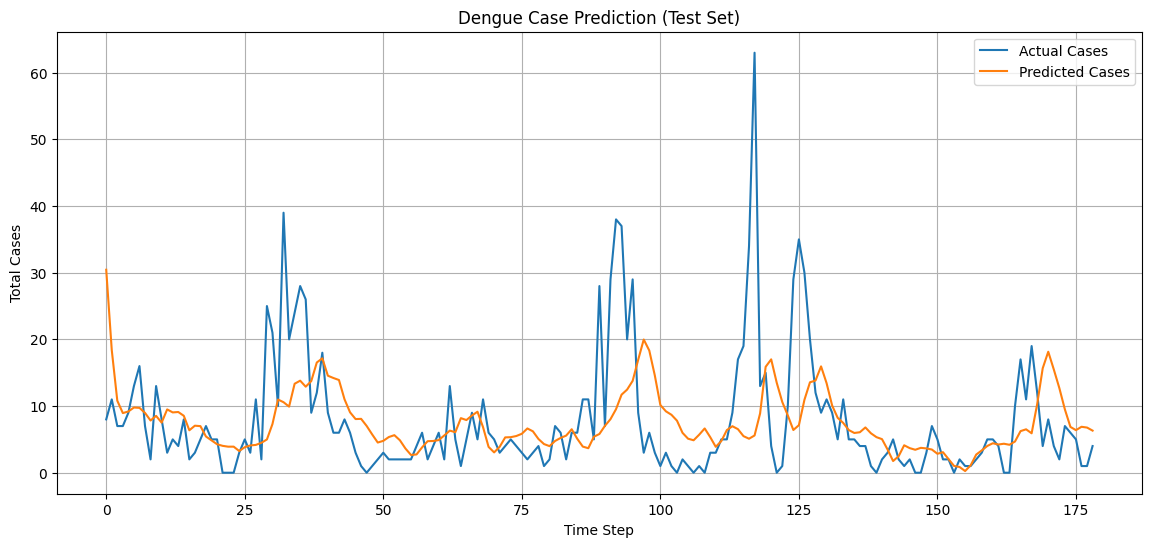

In [18]:
plt.figure(figsize=(14, 6))
plt.plot(actual, label='Actual Cases')
plt.plot(pred, label='Predicted Cases')
plt.title("Dengue Case Prediction (Test Set)")
plt.xlabel("Time Step")
plt.ylabel("Total Cases")
plt.legend()
plt.grid(True)
plt.show()
